# Resultados

In [43]:
library('dplyr')
library('ggplot2')
library('ggrepel')
library('xtable')
library('tidyr')
library('xtable')
library('purrr')
library('readr')
library('tseries')
#install.packages('kableExtra')
library('kableExtra')
options("scipen"=100, "digits"=4)
library('flextable')

# Reading Results

In [3]:
# reading portfolio: 
base.portfolio.ret.2000_1 <- read_rds('./base.portfolio.ret_2000_partI.rds') %>% 
    mutate(date = as.Date(date, format="%Y-%m-%d")) %>% 
    filter(sorted_by=='mean') %>% 
    filter(date < '2021-07-01')

base.portfolio.ret.2000_2 <- read_rds('./base.portfolio.ret_2000_partII.rds') %>% 
    mutate(date = as.Date(date, format="%Y-%m-%d")) %>% 
    filter(sorted_by=='mean') %>% 
    filter(date < '2021-07-01')

base.portfolio.ret.2000_3 <- read_rds('./base.portfolio.ret_2000_partIII.rds') %>% 
    mutate(date = as.Date(date, format="%Y-%m-%d")) %>% 
    filter(sorted_by=='mean') %>% 
    filter(date < '2021-07-01')

# reading cum portfolio:
base.portfolio.cum.ret.2000_1 <- read_rds('./base.portfolio.cum.ret_2000_partI.rds') %>% 
    mutate(date = as.Date(date, format="%Y-%m-%d")) %>% 
    filter(sorted_by=='mean') %>% 
    filter(date < '2021-07-01')

base.portfolio.cum.ret.2000_2 <- read_rds('./base.portfolio.cum.ret_2000_partII.rds') %>% 
    mutate(date = as.Date(date, format="%Y-%m-%d")) %>% 
    filter(sorted_by=='mean') %>% 
    filter(date < '2021-07-01')

base.portfolio.cum.ret.2000_3 <- read_rds('./base.portfolio.cum.ret_2000_partIII.rds') %>% 
    mutate(date = as.Date(date, format="%Y-%m-%d")) %>% 
    filter(sorted_by=='mean') %>% 
    filter(date < '2021-07-01')
    
# datasets union
base.portfolio.ret <- NULL
base.portfolio.cum.ret <- NULL
port.ret <- list(base.portfolio.ret.2000_1, base.portfolio.ret.2000_2, base.portfolio.ret.2000_3)
port.cum.ret <- list(base.portfolio.cum.ret.2000_1, base.portfolio.cum.ret.2000_2, base.portfolio.cum.ret.2000_3)
for(i in 1:3){
    base.portfolio.ret <- rbind(base.portfolio.ret, port.ret[[i]])
    base.portfolio.cum.ret <- rbind(base.portfolio.cum.ret, port.cum.ret[[i]])
}

colnames(base.portfolio.ret) <- c('date', 'sorted_by', 'rebalance_period', 'base', 'top', 'MV', 'MV.LM', 'MV.EW')
colnames(base.portfolio.cum.ret) <- c('date', 'sorted_by', 'rebalance_period', 'base', 'top', 'MV', 'MV.LM', 'MV.EW')


In [4]:
head(base.portfolio.ret)

,date,sorted_by,rebalance_period,base,top,MV,MV.LM,MV.EW
,<date>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,2007-01-03,mean,1,down,6,0.0002747,-0.004796,0.0001536
2,2007-01-04,mean,1,down,6,0.0287742,0.023300,0.0171554
3,2007-01-05,mean,1,down,6,-0.0322210,-0.032517,-0.0323581
4,2007-01-08,mean,1,down,6,0.0125763,0.004298,0.0081409
5,2007-01-09,mean,1,down,6,0.0200468,0.006050,0.0066131
6,2007-01-10,mean,1,down,6,0.0154800,0.009080,0.0110740


In [5]:
# Change labels
base.portfolio.ret <- base.portfolio.ret %>% filter(date < '2021-01-01') %>% 
   mutate(base = ifelse(base == 'down', 'DJIA', 
                            ifelse(base == 'ftse100', 'FTSE100', 
                                   ifelse(base == 'dax', 'DAX', 
                                          ifelse(base == 'nasdaq', 'NASDAQ',
                                                 ifelse(base == 'sp500', 'S&P500',
                                                        ifelse(base == 'nasdaqETF', 'NASDAQ (ETFs)',
                                                               ifelse(base == 'nyse', 'NYSE', ''))))))))

base.portfolio.cum.ret <- base.portfolio.cum.ret %>% filter(date < '2021-01-01') %>% 
   mutate(base = ifelse(base == 'down', 'DJIA', 
                            ifelse(base == 'ftse100', 'FTSE100', 
                                   ifelse(base == 'dax', 'DAX', 
                                          ifelse(base == 'nasdaq', 'NASDAQ',
                                                 ifelse(base == 'sp500', 'S&P500',
                                                        ifelse(base == 'nasdaqETF', 'NASDAQ (ETFs)',
                                                               ifelse(base == 'nyse', 'NYSE', ''))))))))

$$ r_i = ln(p_t/p_{t-1}) $$ 

$$ r_p = w_i \sum_{i=1}^n r_i$$

# Analysis

> ## t test

In [6]:
#*********   t test
summary.port.ret <- base.portfolio.ret %>% 
  mutate('year' = as.numeric(substring(date, 1, 4))) %>%
  select(-MV.EW) %>% 
  pivot_longer(MV:MV.LM, names_to='model', values_to='ret') %>% 
  group_by(year, base, top, model) %>% 
  summarize(mean = round(mean(ret),5),
            sd = round(sd(ret),5)) %>% 
  ungroup() %>% 
  pivot_wider(names_from = 'model', values_from=c('mean', 'sd')) %>% 
  data.frame()
  
t.test <- base.portfolio.ret %>% 
  mutate('year' = as.numeric(substring(date, 1, 4))) %>%
  select(-MV.EW) %>% 
  pivot_longer(MV:MV.LM, names_to='model', values_to='ret') %>% 
  group_by(year, base, top, model) %>% 
  summarise(ret = list(ret)) %>% 
  pivot_wider(names_from = 'model', values_from='ret') %>% 
  group_by(base, top) %>% 
  mutate(t_statistic = t.test(unlist(MV), unlist(MV.LM), var.equal=FALSE)$statistic,
         p_value = t.test(unlist(MV), unlist(MV.LM), var.equal=FALSE)$p.value) %>% 
  select(-MV, -MV.LM) %>% 
  data.frame() %>% 
  mutate('sig(5%)'= ifelse(p_value < 0.05, "*", ""),
         'sig(10%)'= ifelse(p_value < 0.10, "*", ""),
         'sig(15%)'= ifelse(p_value < 0.15, "*", ""))

table_summary <- summary.port.ret %>% 
  merge(t.test, by=c('year','base', 'top'))  %>% 
  filter(year %in% c(2007, 2008, 2009, 2018, 2019, 2020)) %>% 
  arrange(year, base, top) 

  colnames(table_summary) <- c('Year', 'Index', 'Stocks selected' ,'Mean(M1)', 'Mean(M2)', 'sd(M1)', 'sd(M2)',
                               'Statistic(t)', 'P-value', 'Sig(5%)', 'Sig(10%)', 'Sig(15%)')

In [7]:
table_summary 

Year,Index,Stocks selected,Mean(M1),Mean(M2),sd(M1),sd(M2),Statistic(t),P-value,Sig(5%),Sig(10%),Sig(15%)
<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
2007,DAX,6,0.00121,0.00079,0.02378,0.02388,-0.20804,0.8352,,,
2007,DAX,7,0.00134,0.00114,0.02031,0.02113,0.04537,0.9638,,,
2007,DAX,8,0.00118,0.00069,0.01834,0.01946,0.31861,0.7500,,,
2007,DAX,9,0.00113,0.00121,0.01730,0.01856,0.06137,0.9511,,,
2007,DAX,10,0.00091,0.00057,0.01517,0.01531,0.18091,0.8564,,,
2007,DJIA,6,0.00150,0.00164,0.04062,0.03996,0.13229,0.8948,,,
2007,DJIA,7,0.00170,0.00165,0.03361,0.03614,-0.06345,0.9494,,,
2007,DJIA,8,0.00057,0.00062,0.02966,0.02943,0.07768,0.9381,,,
2007,DJIA,9,0.00074,0.00029,0.02743,0.02744,0.18205,0.8555,,,


In [ ]:
# save table in png format
t.test <- flextable(table_summary)
t.test <- autofit(t.test)
save_as_image(t.test, path = "t.test_2007_2020.png")

> ## F test

In [8]:
#*********   F test (compare two variances)
summary.F <- base.portfolio.ret %>% 
  mutate('year' = as.numeric(substring(date, 1, 4))) %>%
  select(-MV.EW) %>% 
  pivot_longer(MV:MV.LM, names_to='model', values_to='ret') %>% 
  group_by(year, base, top) %>% 
  summarise('F_statistic'= round(var.test(ret~model,alternative='two.sided', ratio = 1)$statistic,5),
            'F_p.value'= round(var.test(ret~model,alternative='two.sided', ratio = 1)$p.value,5)) %>% 
  ungroup() %>% 
  mutate('sig(5%)'= ifelse(F_p.value < 0.05, "*", ""),
         'sig(10%)'= ifelse(F_p.value < 0.10, "*", ""),
         'sig(15%)'= ifelse(F_p.value < 0.15, "*", ""))

table_summary_F <- summary.port.ret %>% 
  merge(summary.F, by=c('year','base', 'top')) %>%  
  filter(year %in% c(2007, 2008, 2009, 2018, 2019, 2020)) %>% 
  arrange(year, base, top) 

  colnames(table_summary_F) <- c('Year', 'Index', 'Stocks selected' ,'Mean(M1)', 'Mean(M2)', 'sd(M1)', 'sd(M2)',
                               'Statistic(F)', 'P-value', 'Sig(5%)', 'Sig(10%)', 'Sig(15%)')

In [9]:
# F table result
head(table_summary_F)

,Year,Index,Stocks selected,Mean(M1),Mean(M2),sd(M1),sd(M2),Statistic(F),P-value,Sig(5%),Sig(10%),Sig(15%)
,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,2007,DAX,6,0.00121,0.00079,0.02378,0.02388,0.9913,0.9452,,,
2,2007,DAX,7,0.00134,0.00114,0.02031,0.02113,0.9244,0.5340,,,
3,2007,DAX,8,0.00118,0.00069,0.01834,0.01946,0.8878,0.3463,,,
4,2007,DAX,9,0.00113,0.00121,0.01730,0.01856,0.8684,0.2642,,,
5,2007,DAX,10,0.00091,0.00057,0.01517,0.01531,0.9818,0.8847,,,
6,2007,DJIA,6,0.00150,0.00164,0.04062,0.03996,1.0331,0.7970,,,


In [ ]:
table_summary_F %>%
  kbl(format="latex",
      col.names = colnames(table_summary_F),
      align="r",
      caption="Summary Statistics of Financial Well-Being Score by Gender and Education") %>%
  kable_minimal(full_width = F,  html_font = "Source Sans Pro")

In [ ]:
# save table in png format
F.test <- flextable(table_summary_F)
F.test <- autofit(F.test)
save_as_image(F.test, path = "F.test_2007_2020.png")

> ## Autocorrelation test (Ljung-Box test)


Sometimes it is important to prove if the values of a time serie, let's say $r_t$, are independent. We can say that there is an autocorrelation pattern if the serie are serially correlated. A widely used test to verify whether a series of values are correlated is Ljung Box statistics which are based in autocorrelation as a set. Suppose we are given $m$ values autocorrelations.  We test the following joint null hypothesis about the correlations among the values
\begin{equation}
H_0 : \rho_1 = ... = \rho_k = 0
\end{equation}
with the statistic
\begin{equation}
Q  =  n(n+2) \sum_{k=1}^{m} \frac{\hat{\rho}_k^2}{(n-k)} 
\end{equation} 
where $m$ is the number of lags under test, and $\hat{\rho}_k^2$ represents $\hat{Cov} (r_t, r_{t+k})$ for $k=1,...,m$. 

For reference see Pankratz($1983$).

In [10]:
#********* Ljung-Box test for independence
Ljung.Box_test <- base.portfolio.ret %>% 
  mutate('year' = as.numeric(substring(date, 1, 4))) %>%
  select(-MV.EW) %>% 
  pivot_longer(MV:MV.LM, names_to='model', values_to='ret') %>% 
  group_by(year, base, top, model) %>% 
  summarise(ret = list(ret)) %>% 
  pivot_wider(names_from = 'model', values_from='ret') %>% 
  group_by(year, base, top) %>% 
  mutate(M1_Stat = round(Box.test(unlist(MV), lag=25, type="Ljung-Box")$statistic,4),
         M2_Stat = round(Box.test(unlist(MV.LM), lag=25, type="Ljung-Box")$statistic,4),
         M1_p.value = round(Box.test(unlist(MV), lag=25, type="Ljung-Box")$p.value,4),
         M2_p.value = round(Box.test(unlist(MV.LM), lag=25, type="Ljung-Box")$p.value,4)) %>% 
  select(-MV, -MV.LM) %>%      
  data.frame() %>% 
  mutate('M1_sig(5%)' = ifelse( M1_p.value < 0.05, "*", ""),
         'M1_sig(10%)' = ifelse( M1_p.value < 0.10, "*", ""),
         'M2_sig(5%)' = ifelse( M2_p.value < 0.05, "*", ""),
         'M2_sig(10%)' = ifelse( M2_p.value < 0.10, "*", ""))

colnames(Ljung.Box_test) <- c('Year', 'Index', 'Stocks selected' ,'Mean(M1)', 'Mean(M2)',
                               'P-value(M1)', 'P-value(M2)', 'Sig(5%)(M1)', 'Sig(10%)(M1)', 
                               'Sig(5%)(M2)', 'Sig(10%)(M2)')
head(Ljung.Box_test)

,Year,Index,Stocks selected,Mean(M1),Mean(M2),P-value(M1),P-value(M2),Sig(5%)(M1),Sig(10%)(M1),Sig(5%)(M2),Sig(10%)(M2)
,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,2007,DAX,6,15.26,16.69,0.9350,0.8929,,,,
2,2007,DAX,7,19.36,16.16,0.7794,0.9099,,,,
3,2007,DAX,8,16.50,16.89,0.8991,0.8858,,,,
4,2007,DAX,9,18.35,17.82,0.8270,0.8501,,,,
5,2007,DAX,10,15.98,22.10,0.9155,0.6299,,,,
6,2007,DJIA,6,34.87,33.74,0.0905,0.1135,,*,,


In [ ]:
Ljung.Box_table <- Ljung.Box_test %>%
  filter(Year %in% c(2007:2009, 2018:2020)) %>% 
  kbl(format="latex",
      col.names = colnames(Ljung.Box_test),
      align="r",
      caption="Ljung.Box_test") %>%
  kable_minimal(full_width = F,  html_font = "Source Sans Pro")

> ## Augmented Dickey-Fuller test (ADF)



- H_0 :  existencia de raíz unitaria (serie no estacionaria)
- H_a :  no existencia de raíz unitaria (serie estacionaria)

In [12]:
# prueba de ADF
ADF_test <- base.portfolio.ret %>% 
  mutate('year' = as.numeric(substring(date, 1, 4))) %>%
  select(-MV.EW) %>% 
  pivot_longer(MV:MV.LM, names_to='model', values_to='ret') %>% 
  group_by(year, base, top, model) %>% 
  summarise(ret = list(ret)) %>% 
  pivot_wider(names_from = 'model', values_from='ret') %>% 
  group_by(year, base, top) %>% 
  mutate(M1_Stat = round(adf.test(unlist(MV))$statistic,4),
         M2_Stat = round(adf.test(unlist(MV.LM))$statistic,4),
         M1_p.value = round(adf.test(unlist(MV))$p.value,4),
         M2_p.value = round(adf.test(unlist(MV.LM))$p.value,4)) %>% 
  select(-MV, -MV.LM) %>%      
  data.frame() %>% 
  mutate('M1_sig(5%)' = ifelse( M1_p.value < 0.05, "*", ""),
         'M1_sig(10%)' = ifelse( M1_p.value < 0.10, "*", ""),
         'M2_sig(5%)' = ifelse( M2_p.value < 0.05, "*", ""),
         'M2_sig(10%)' = ifelse( M2_p.value < 0.10, "*", ""))

colnames(ADF_test) <- c('Year', 'Index', 'Stocks selected' ,'Statistic (M1)', 'Statistic (M2)',
                        'P-value (M1)', 'P-value (M2)', 'Sig(5%)(M1)', 'Sig(10%)(M1)', 
                        'Sig(5%)(M2)', 'Sig(10%)(M2)')
ADF_test

Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):
"p-value smaller than printed p-value"
Warning message in adf.test(unlist(MV)):

Year,Index,Stocks selected,Statistic (M1),Statistic (M2),P-value (M1),P-value (M2),Sig(5%)(M1),Sig(10%)(M1),Sig(5%)(M2),Sig(10%)(M2)
<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
2007,DAX,6,-7.157,-7.277,0.01,0.01,*,*,*,*
2007,DAX,7,-7.292,-7.082,0.01,0.01,*,*,*,*
2007,DAX,8,-6.894,-6.945,0.01,0.01,*,*,*,*
2007,DAX,9,-7.218,-7.155,0.01,0.01,*,*,*,*
2007,DAX,10,-6.972,-7.484,0.01,0.01,*,*,*,*
2007,DJIA,6,-7.123,-7.178,0.01,0.01,*,*,*,*
2007,DJIA,7,-6.928,-6.706,0.01,0.01,*,*,*,*
2007,DJIA,8,-7.034,-7.017,0.01,0.01,*,*,*,*
2007,DJIA,9,-7.184,-7.197,0.01,0.01,*,*,*,*


# Box Plot

In [13]:
base.port.ret.by_year <- base.portfolio.ret %>% 
    mutate('year'=as.numeric(substring(date,1,4))) %>% 
    select(-date, -sorted_by, -rebalance_period, -MV.EW) %>% 
    rename(Index=base, 'Stocks_Selected'=top, M1=MV, M2=MV.LM, Year=year)
 
head(base.port.ret.by_year)

,Index,Stocks_Selected,M1,M2,Year
,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,DJIA,6,0.0002747,-0.004796,2007
2,DJIA,6,0.0287742,0.023300,2007
3,DJIA,6,-0.0322210,-0.032517,2007
4,DJIA,6,0.0125763,0.004298,2007
5,DJIA,6,0.0200468,0.006050,2007
6,DJIA,6,0.0154800,0.009080,2007


In [14]:
base.ret <- base.port.ret.by_year %>%
  gather(key='Modelo',value='portfolio.return',-Year,-Stocks_Selected,-Index) %>% 
  group_by(Year, Index, Stocks_Selected, Modelo) %>% 
  summarize('mean'=mean(portfolio.return),
            'sd' = sd(portfolio.return),
            'sr' = mean/sd) %>%
  ungroup() %>%
  data.frame() %>% 
  arrange(Year, Index, Stocks_Selected, desc(sr)) %>% 
  filter(Modelo != 'MV.EW')


In [15]:
head(base.ret)

,Year,Index,Stocks_Selected,Modelo,mean,sd,sr
,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,2007,DAX,6,M1,0.0012061,0.02378,0.05072
2,2007,DAX,6,M2,0.0007891,0.02388,0.03304
3,2007,DAX,7,M1,0.0013441,0.02031,0.06617
4,2007,DAX,7,M2,0.0011410,0.02113,0.05401
5,2007,DAX,8,M1,0.0011832,0.01834,0.06452
6,2007,DAX,8,M2,0.0006944,0.01946,0.03568


> ## Period: 2007-2009

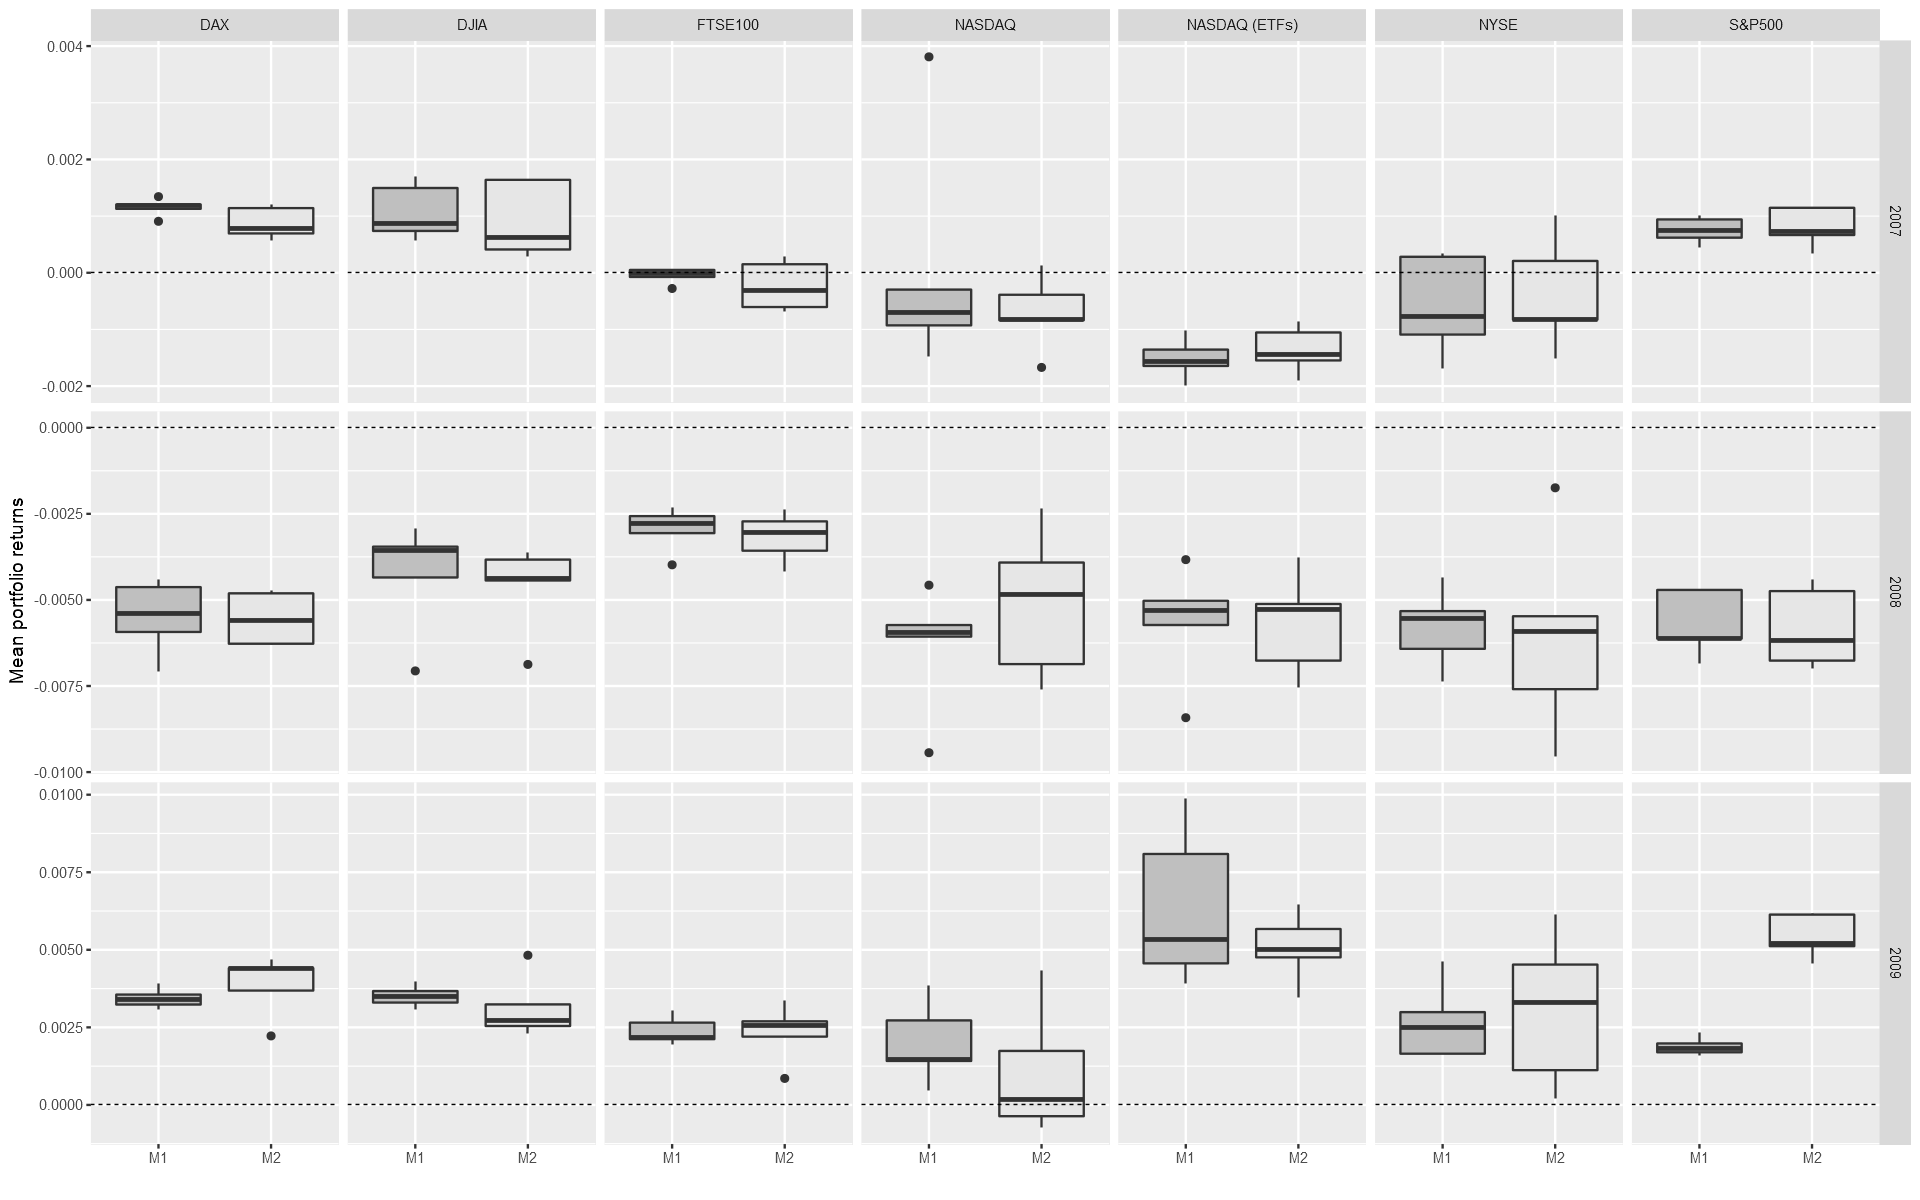

In [16]:
options(repr.plot.width=16, repr.plot.height=10)
b1 <- ggplot(base.ret %>% filter(Year %in% c(2007:2009)), aes(x=Modelo, y=mean, fill=Modelo)) +
  geom_boxplot() +
  #stat_summary(fun.y="mean", color='blue') +
  geom_hline(yintercept=0, linetype="dashed", color = "black", size=0.3) +
  facet_grid(col=vars(Index), row=vars(Year), scale='free') +
  labs(y="Mean portfolio returns", x="") +
  #labs(y="Mean portfolio returns", x="", caption='Training period : last 7 years \n
  #                                                Testing period : 2007.01-2019.12 \n
  #                                                Rolling window : 1 month') +
  theme(legend.position="none",
        legend.box = "horizontal",
        legend.title = element_blank()) +
  scale_fill_grey(start=0.75, end=0.9)
b1

In [95]:
png(file="Boxplot_2007_to_2009.png",width=1000, height=600)
b1
dev.off()

png 
  2

> ## Period: 2018-2020

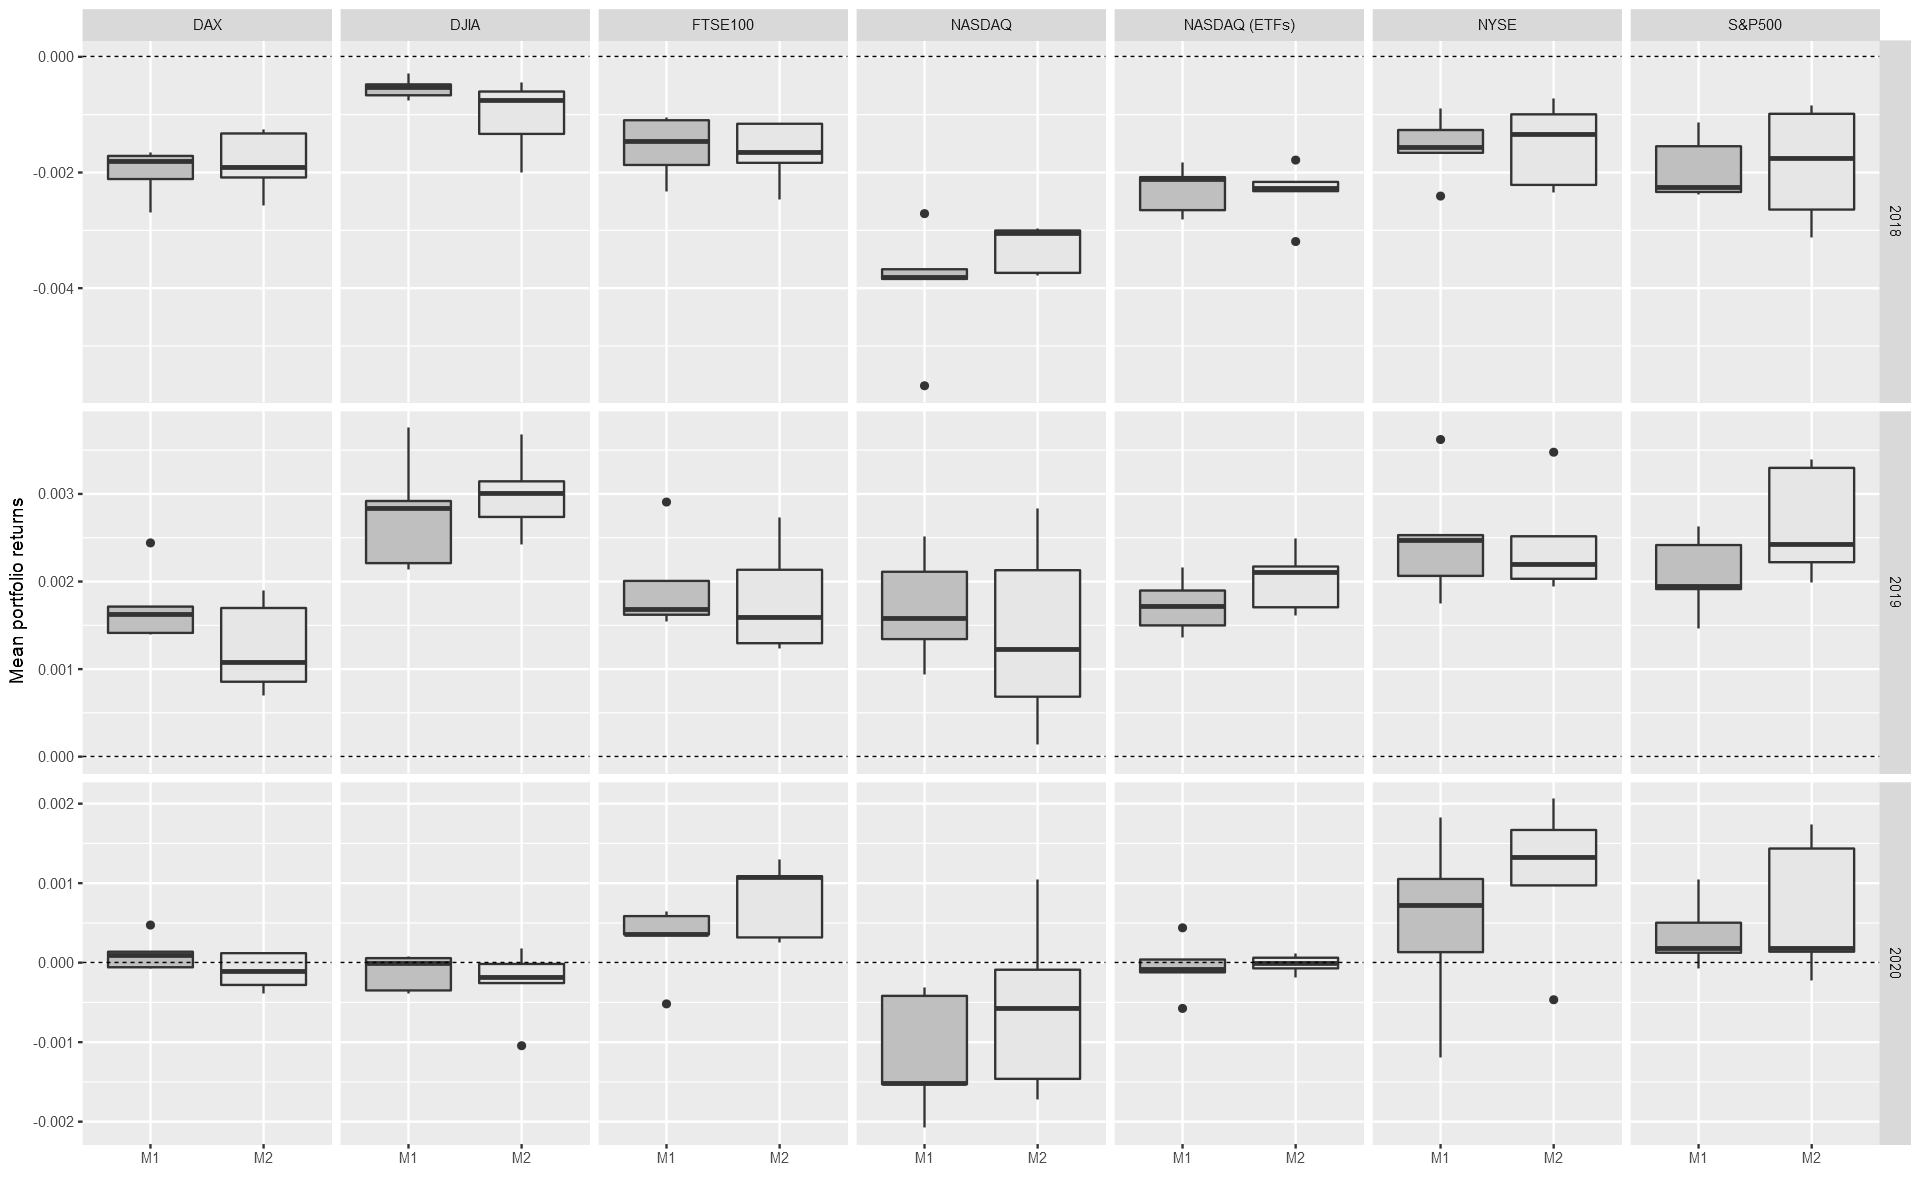

In [17]:
options(repr.plot.width=16, repr.plot.height=10)
b2 <- ggplot(base.ret %>% filter(Year %in% c(2018:2020)), aes(x=Modelo, y=mean, fill=Modelo)) +
  geom_boxplot() +
  #stat_summary(fun.y="mean", color='blue') +
  geom_hline(yintercept=0, linetype="dashed", color = "black", size=0.3) +
  facet_grid(col=vars(Index), row=vars(Year), scale='free') +
  labs(y="Mean portfolio returns", x="") +
  #labs(y="Mean portfolio returns", x="", caption='Training period : last 7 years \n
  #                                                Testing period : 2018.01-2020.12 \n
  #                                                Rolling window : 1 month') +
  theme(legend.position="none",
        legend.box = "horizontal",
        legend.title = element_blank()) +
  scale_fill_grey(start=0.75, end=0.9)
b2

In [97]:
png(file="Boxplot_2018_to_2020.png", width=1000, height=600)
b2
dev.off()

png 
  2

# Cumulative returns

In [18]:
head(base.portfolio.ret)

,date,sorted_by,rebalance_period,base,top,MV,MV.LM,MV.EW
,<date>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,2007-01-03,mean,1,DJIA,6,0.0002747,-0.004796,0.0001536
2,2007-01-04,mean,1,DJIA,6,0.0287742,0.023300,0.0171554
3,2007-01-05,mean,1,DJIA,6,-0.0322210,-0.032517,-0.0323581
4,2007-01-08,mean,1,DJIA,6,0.0125763,0.004298,0.0081409
5,2007-01-09,mean,1,DJIA,6,0.0200468,0.006050,0.0066131
6,2007-01-10,mean,1,DJIA,6,0.0154800,0.009080,0.0110740


In [19]:

base.ret <- base.portfolio.ret %>%
  gather(key='Modelo',value='return',-date, -sorted_by, -rebalance_period, -base, -top) %>% 
  filter(date < '2021-01-01', Modelo %in% c('MV', 'MV.LM'))

base.cum.ret <- base.portfolio.cum.ret %>%
  gather(key='Modelo',value='cumulative.return',-date, -sorted_by, -rebalance_period, -base, -top) %>% 
  filter(date < '2021-01-01', Modelo %in% c('MV', 'MV.LM'))



> ## Portfolio returns

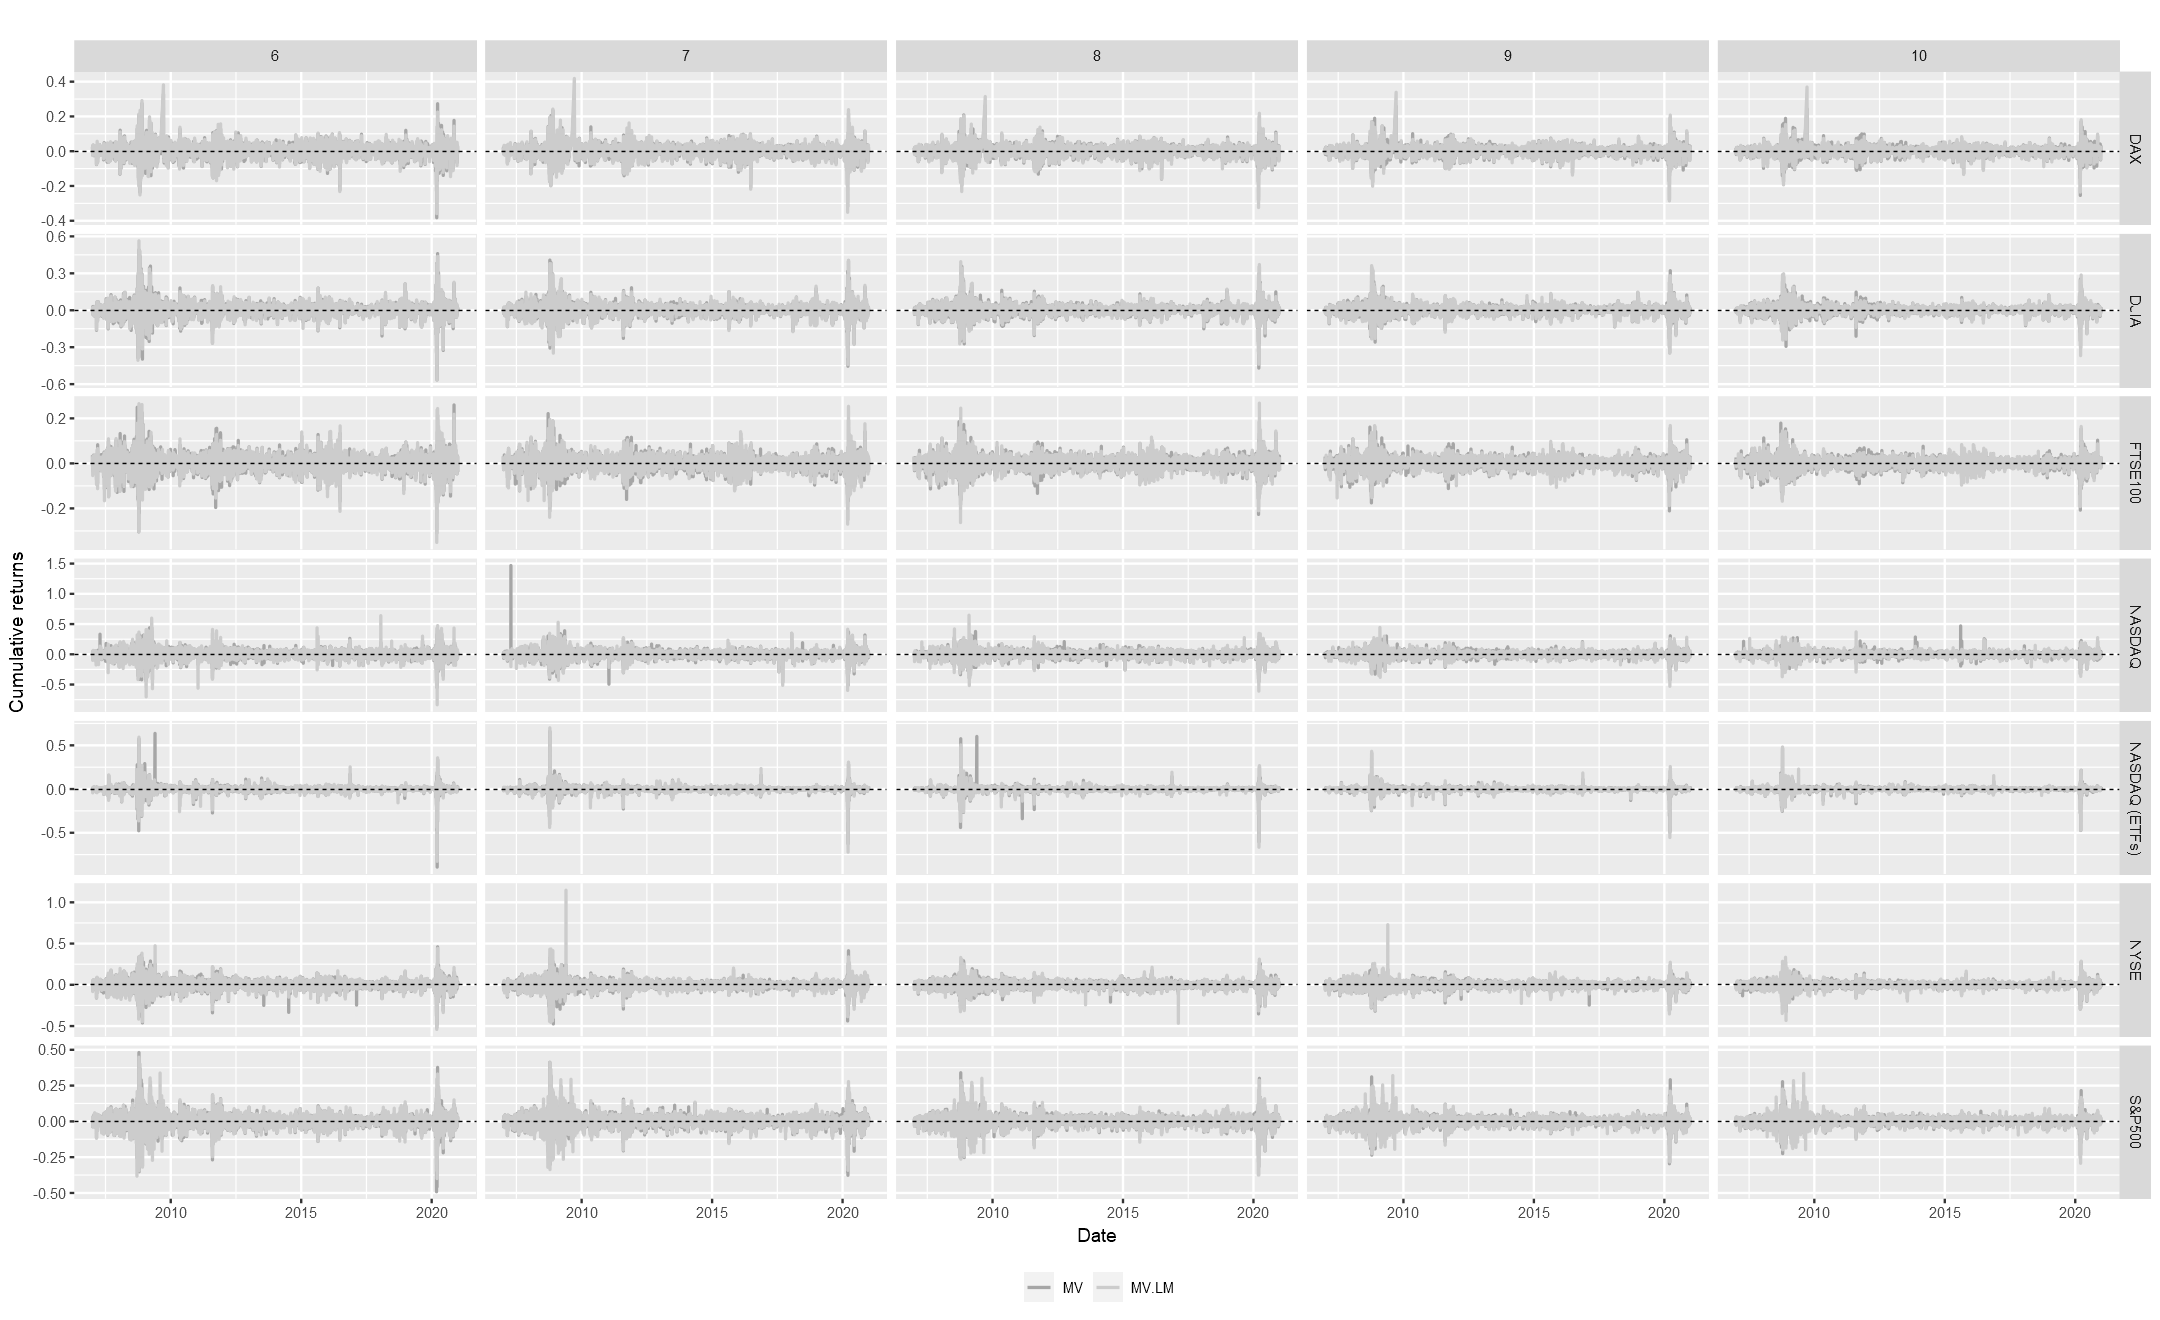

In [20]:
options(repr.plot.width=18, repr.plot.height=11)
p3 <- ggplot(base.ret  , aes(x=date,y=return,color=Modelo) )+
  geom_line(size=0.7) +
  #theme_minimal() +
  geom_hline(yintercept=0, linetype="dashed", color = "black", size=0.3) +
  #theme(legend.position="bottom",
  #      legend.title = element_blank(),
  #      legend.text = element_text(colour="black", size=12)) +
  labs(title="",x='Date',y='Cumulative returns') +
  #facet_grid(top ~ .) 
  facet_grid(col=vars(top), row=vars(base), scale="free") +
  theme(legend.position="bottom",
        legend.box = "horizontal",
        legend.title = element_blank()) +
  scale_color_grey(start=0.65, end=0.8)
p3

> # Cumulative returns

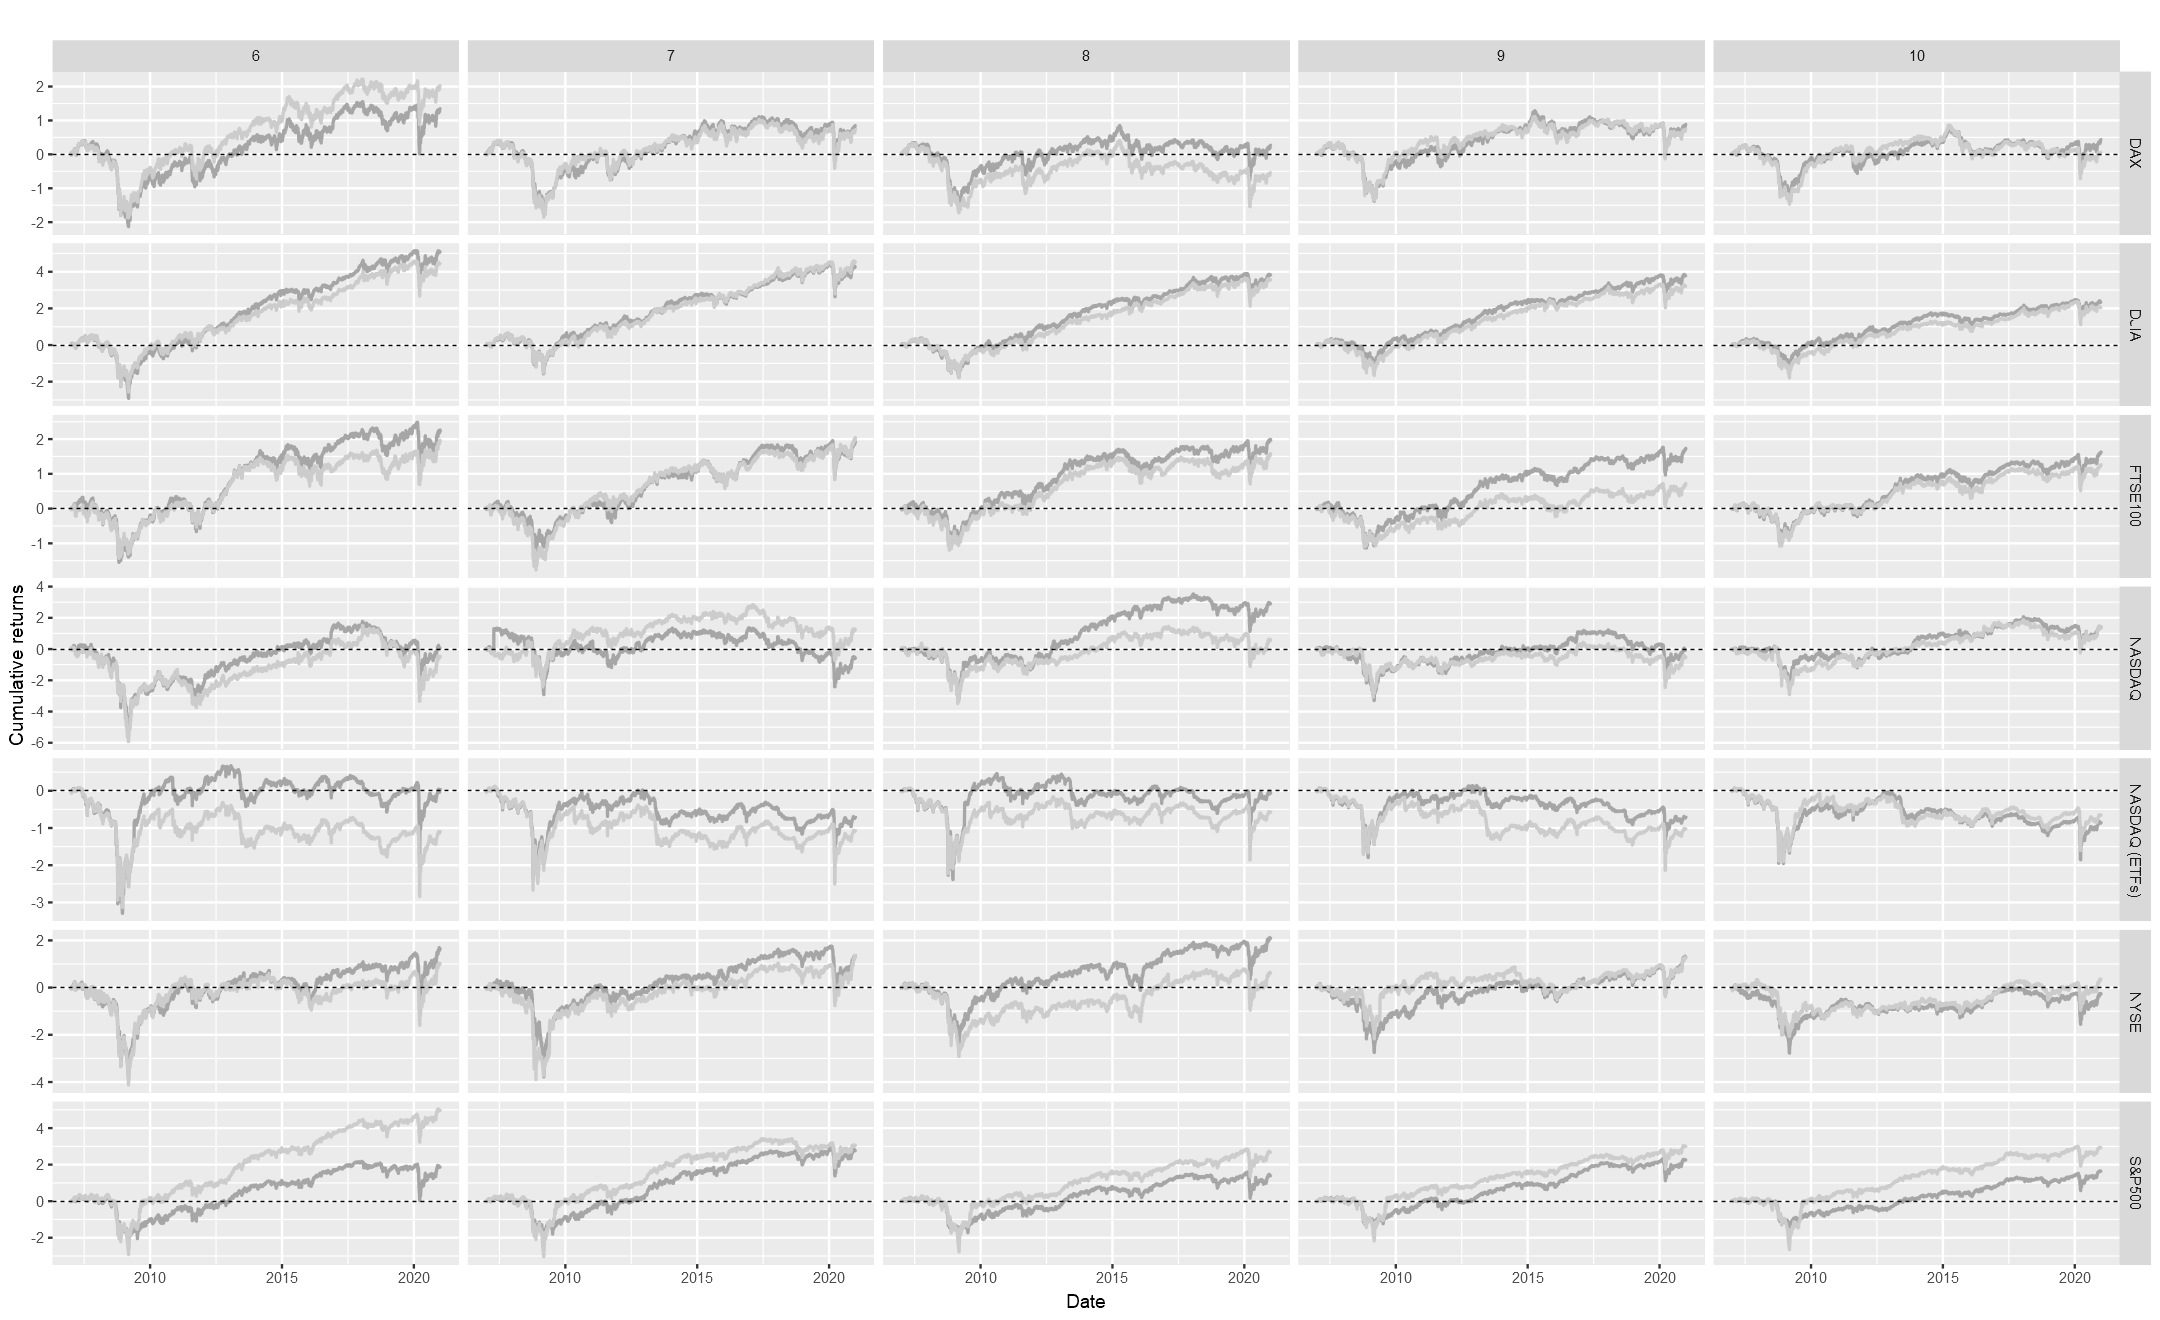

In [21]:
options(repr.plot.width=18, repr.plot.height=11)
p4 <- ggplot(base.cum.ret  , aes(x=date,y=cumulative.return,color=Modelo) )+
  geom_line(size=0.7) +
  #theme_minimal() +
  geom_hline(yintercept=0, linetype="dashed", color = "black", size=0.3) +
  #theme(legend.position="bottom",
  #      legend.title = element_blank(),
  #      legend.text = element_text(colour="black", size=12)) +
  labs(title="",x='Date',y='Cumulative returns') +
  #facet_grid(top ~ .) 
  facet_grid(col=vars(top), row=vars(base), scale="free") +
  theme(legend.position="none",
        legend.box = "horizontal",
        legend.title = element_blank()) +
  scale_color_grey(start=0.65, end=0.8)
p4

In [104]:
png(file="cumulative_returns.png", width=1000, height=600)
p4
dev.off()

png 
  2